## FlatFault-A

## 2D foundation velocity model loading

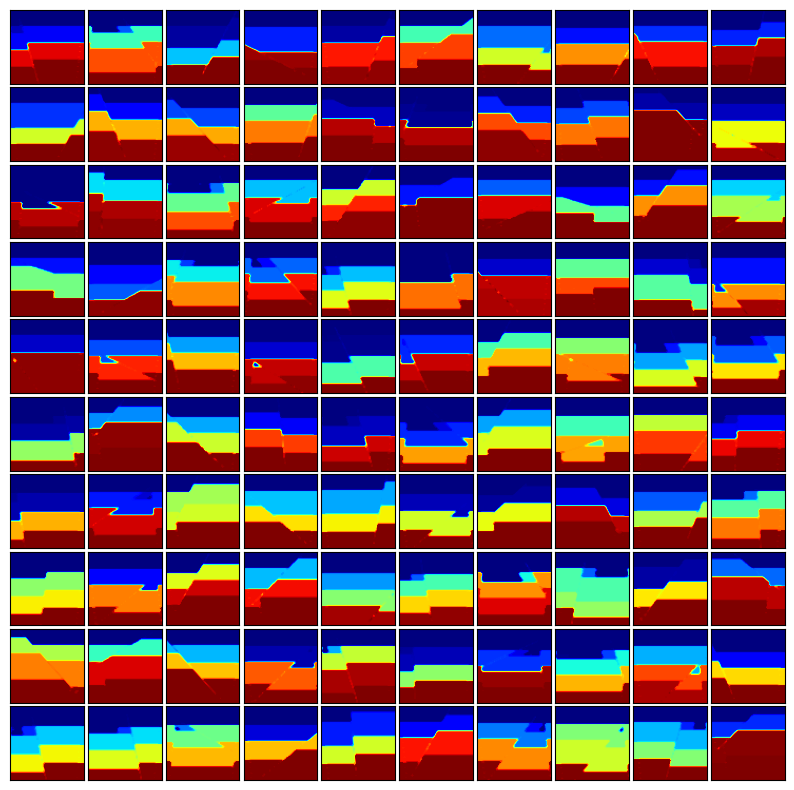

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../")
from SWIDP.process_1d_shallow import *
from SWIDP.dispersion import *
from p_tqdm import p_map


data_base_path = "../../../OpenSWI/Datasets/Original/OpenSWI-shallow/FlatFault_A/model"

models_list = os.listdir(data_base_path)


models_path_list = []
for model_name in models_list:
    model_path = os.path.join(data_base_path, model_name)
    models_path_list.append(model_path)


vel_model_subsets0 = np.load(models_path_list[10])
vel_model_subsets0 = vel_model_subsets0.squeeze()

nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(vel_model_subsets0[i*ncols+j],cmap="jet")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()


## Single Velocity Model Preparation

### Step 1: Velocity extraction

In [3]:
from SWIDP.dispersion import *

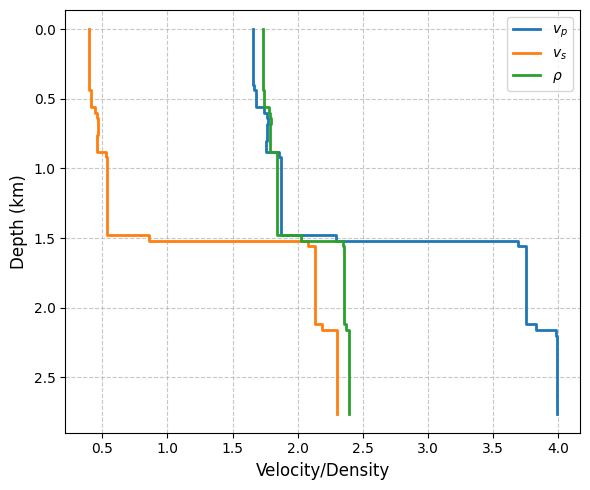

In [4]:
# extract 1 velocity profile
vp = vel_model_subsets0[0,:,10]/1000

# transform vp to vs using the empirical relation
vs = transform_vp_to_vs(vp)
depth = np.arange(len(vs))*0.04
vel_model = transform_vs_to_vel_model(vs,depth=depth)

# figure the velocity model
plt.figure(figsize=(6, 5))
plt.step(vel_model[:, 1], vel_model[:, 0], label=r"$v_p$", linewidth=2)
plt.step(vel_model[:, 2], vel_model[:, 0], label=r"$v_s$", linewidth=2) 
plt.step(vel_model[:, 3], vel_model[:, 0], label=r"$\rho$", linewidth=2)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Velocity/Density', fontsize=12)
plt.ylabel('Depth (km)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Step2: Surface Wave Dispersion Curve Modeling

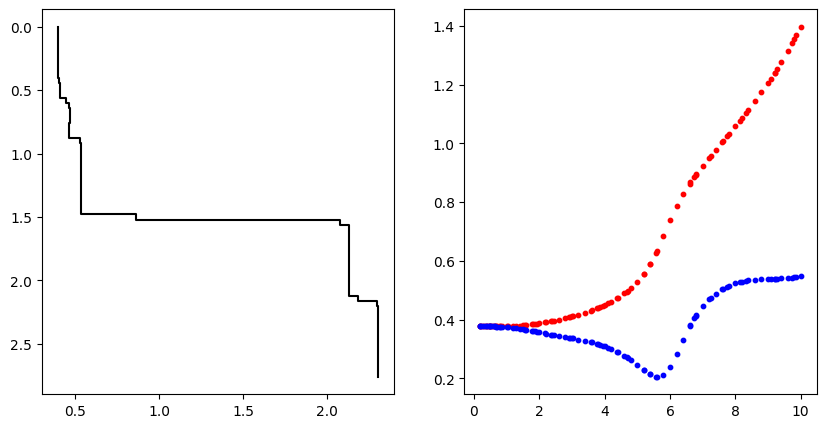

In [5]:
t = generate_mixed_samples(num_samples=100,start=0.2,end=10,uniform_num=50,log_num=20,random_num=30)

disp_original = calculate_dispersion(vel_model,t=t)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.step(vel_model[:,2],depth,c='k',label='Original')
plt.gca().invert_yaxis()

plt.subplot(122)
plt.scatter(disp_original[:,0],disp_original[:,1],s=10,c='r')
plt.scatter(disp_original[:,0],disp_original[:,2],s=10,c='b')
plt.show()

## Multiple Velocity Profiles Preparation

### Step1: extract multiple 1D velocity models

  0%|          | 0/500 [00:00<?, ?it/s]

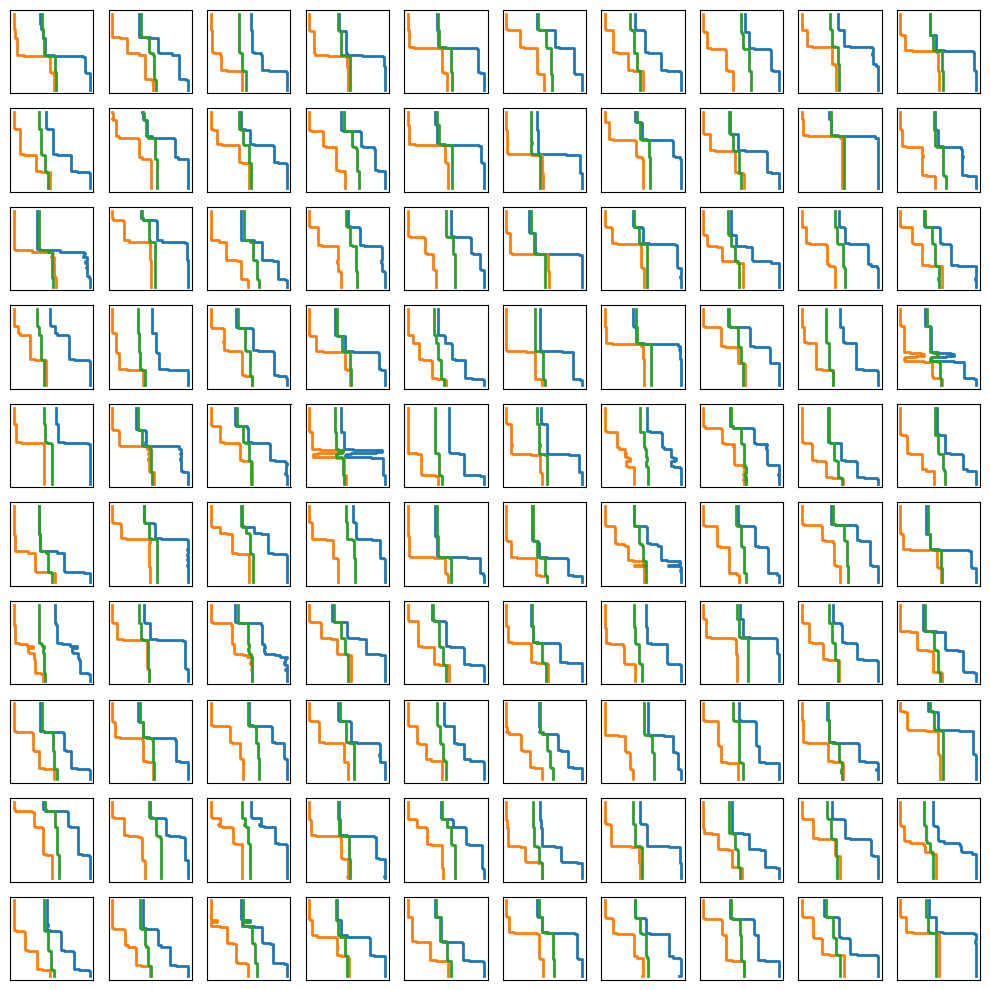

In [6]:
# extract 1 velocity profile
vp = vel_model_subsets0[:,:,10]/1000

# transform vp to vs using the empirical relation
vs = transform_vp_to_vs(vp)
depth = np.arange(vs.shape[-1])*0.04
vel_models = p_map(transform_vs_to_vel_model,list(vs),[depth]*len(vs))
vel_models = np.array(vel_models)

# figure the velocity model
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].step(vel_models[i*ncols+j][:, 1], vel_models[i*ncols+j][:, 0], label=r"$v_p$", linewidth=2)
        axs[i,j].step(vel_models[i*ncols+j][:, 2], vel_models[i*ncols+j][:, 0], label=r"$v_s$", linewidth=2) 
        axs[i,j].step(vel_models[i*ncols+j][:, 3], vel_models[i*ncols+j][:, 0], label=r"$\rho$", linewidth=2)
        axs[i,j].invert_yaxis()
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.tight_layout()
plt.show()


### Step 2: Calculate the corresponding dispersion curves

  0%|          | 0/500 [00:00<?, ?it/s]

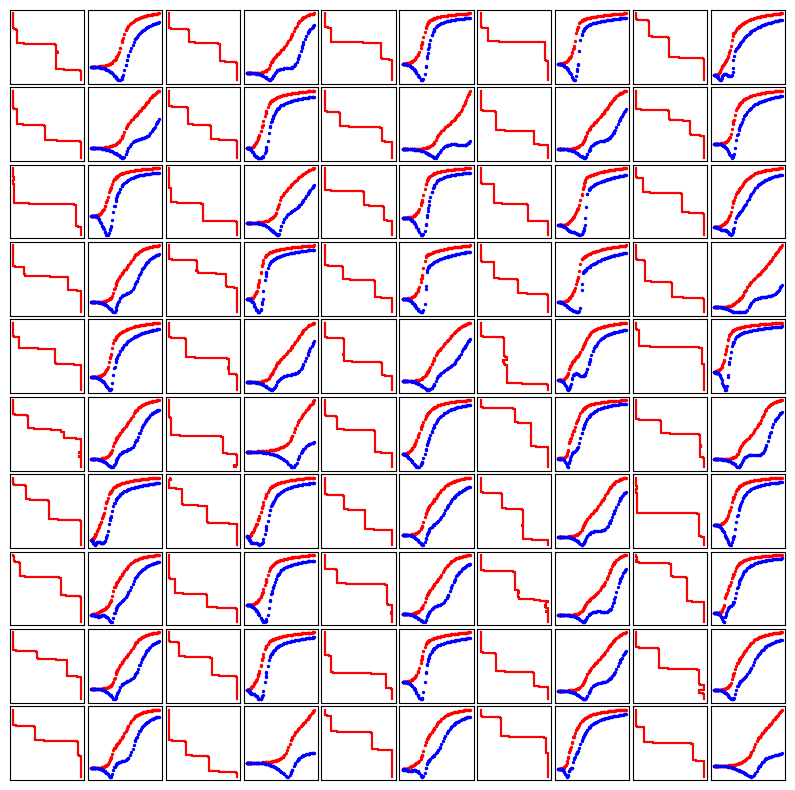

In [7]:
# calculate the dispersion curves
disp_data = p_map(calculate_dispersion,vel_models,[t]*len(vel_models))

# convert the list to numpy array
disp_data = np.array(disp_data)



# figure all the augmented vs models
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='r')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

## Process All the OpenFWI-FlatVel datasets

In [ ]:
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-shallow/0.2-10s-Base/"

# Initialize empty lists to store data
disp_data_all  = []
vel_models_all = []

try:
# Process each model file
    for path in models_path_list:
        # Load and preprocess velocity model
        vp_model_subset = np.load(path).squeeze()
        vp_model_subset = np.swapaxes(vp_model_subset, 1, 2)
        vp_model_subset = vp_model_subset.reshape(-1, vp_model_subset.shape[-1])[::10]/1000
        vp_model_subset = np.unique(vp_model_subset, axis=0)

        # perturb the vp model
        vp_model_subset = np.array(vp_model_subset).reshape(-1,70)
        vp_model_subset = vp_model_subset[vp_model_subset.sum(axis=1) > 0]

        # transform vp to vs
        vs_models = transform_vp_to_vs(vp_model_subset)

        # transform vs to [depth,vp,vs,rho] model
        vel_models = p_map(transform_vs_to_vel_model, list(vs_models), [depth]*len(vs_models))

        # Calculate dispersion curves
        disp_data = p_map(calculate_dispersion, vel_models)
        disp_data = np.array(disp_data)
        
        # Store results
        disp_data_all.extend(disp_data)
        vel_models_all.extend(vel_models)

    # Convert lists to numpy arrays and reshape
    disp_data_all = np.array(disp_data_all)
    vel_models_all = np.array(vel_models_all)

    # Filter out zero dispersion curves and corresponding velocity models
    valid_indices  = ~np.all(disp_data_all == 0, axis=(1,2))
    disp_data_all  = disp_data_all[valid_indices]
    vel_models_all = vel_models_all[valid_indices]

    # Create output directory if it doesn't exist
    os.makedirs(save_base_path, exist_ok=True)

    # Save processed data as compressed npz files
    np.savez_compressed(os.path.join(save_base_path, "FlatFaultA_model.npz"),
                       data=vel_models_all.astype(np.float32))
    np.savez_compressed(os.path.join(save_base_path, "FlatFaultA_disp.npz"),
                       data=disp_data_all.astype(np.float32))
                    
except Exception as e:
    print(f"An error occurred during processing: {str(e)}")

  0%|          | 0/2706 [00:00<?, ?it/s]

  0%|          | 0/2706 [00:00<?, ?it/s]

  0%|          | 0/2666 [00:00<?, ?it/s]

  0%|          | 0/2666 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2708 [00:00<?, ?it/s]

  0%|          | 0/2642 [00:00<?, ?it/s]

  0%|          | 0/2642 [00:00<?, ?it/s]

  0%|          | 0/2636 [00:00<?, ?it/s]

  0%|          | 0/2636 [00:00<?, ?it/s]

  0%|          | 0/2624 [00:00<?, ?it/s]

  0%|          | 0/2624 [00:00<?, ?it/s]

  0%|          | 0/2736 [00:00<?, ?it/s]

  0%|          | 0/2736 [00:00<?, ?it/s]

  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/2714 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2791 [00:00<?, ?it/s]

  0%|          | 0/2791 [00:00<?, ?it/s]

  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/2757 [00:00<?, ?it/s]

  0%|          | 0/2688 [00:00<?, ?it/s]

  0%|          | 0/2688 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

  0%|          | 0/2731 [00:00<?, ?it/s]

  0%|          | 0/2731 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2746 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2733 [00:00<?, ?it/s]

  0%|          | 0/2733 [00:00<?, ?it/s]

  0%|          | 0/2777 [00:00<?, ?it/s]

  0%|          | 0/2777 [00:00<?, ?it/s]

  0%|          | 0/2719 [00:00<?, ?it/s]

  0%|          | 0/2719 [00:00<?, ?it/s]

  0%|          | 0/2743 [00:00<?, ?it/s]

  0%|          | 0/2743 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2647 [00:00<?, ?it/s]

  0%|          | 0/2647 [00:00<?, ?it/s]

  0%|          | 0/2689 [00:00<?, ?it/s]

  0%|          | 0/2689 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2747 [00:00<?, ?it/s]

  0%|          | 0/2747 [00:00<?, ?it/s]

  0%|          | 0/2663 [00:00<?, ?it/s]

  0%|          | 0/2663 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/2700 [00:00<?, ?it/s]

  0%|          | 0/2728 [00:00<?, ?it/s]

  0%|          | 0/2728 [00:00<?, ?it/s]

  0%|          | 0/2724 [00:00<?, ?it/s]

  0%|          | 0/2724 [00:00<?, ?it/s]

  0%|          | 0/2697 [00:00<?, ?it/s]

  0%|          | 0/2697 [00:00<?, ?it/s]

  0%|          | 0/2677 [00:00<?, ?it/s]

  0%|          | 0/2677 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/2752 [00:00<?, ?it/s]

  0%|          | 0/2752 [00:00<?, ?it/s]

  0%|          | 0/2812 [00:00<?, ?it/s]

  0%|          | 0/2812 [00:00<?, ?it/s]

  0%|          | 0/2742 [00:00<?, ?it/s]

  0%|          | 0/2742 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2720 [00:00<?, ?it/s]

  0%|          | 0/2668 [00:00<?, ?it/s]

  0%|          | 0/2668 [00:00<?, ?it/s]

  0%|          | 0/2682 [00:00<?, ?it/s]

  0%|          | 0/2682 [00:00<?, ?it/s]

  0%|          | 0/2691 [00:00<?, ?it/s]

  0%|          | 0/2691 [00:00<?, ?it/s]

  0%|          | 0/2758 [00:00<?, ?it/s]

  0%|          | 0/2758 [00:00<?, ?it/s]

  0%|          | 0/2750 [00:00<?, ?it/s]

  0%|          | 0/2750 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2758 [00:00<?, ?it/s]

  0%|          | 0/2758 [00:00<?, ?it/s]

  0%|          | 0/2816 [00:00<?, ?it/s]

  0%|          | 0/2816 [00:00<?, ?it/s]

  0%|          | 0/2688 [00:00<?, ?it/s]

  0%|          | 0/2688 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2683 [00:00<?, ?it/s]

  0%|          | 0/2683 [00:00<?, ?it/s]

  0%|          | 0/2693 [00:00<?, ?it/s]

  0%|          | 0/2693 [00:00<?, ?it/s]

  0%|          | 0/2682 [00:00<?, ?it/s]

  0%|          | 0/2682 [00:00<?, ?it/s]

  0%|          | 0/2629 [00:00<?, ?it/s]

  0%|          | 0/2629 [00:00<?, ?it/s]

  0%|          | 0/2697 [00:00<?, ?it/s]

  0%|          | 0/2697 [00:00<?, ?it/s]

  0%|          | 0/2654 [00:00<?, ?it/s]

  0%|          | 0/2654 [00:00<?, ?it/s]

  0%|          | 0/2686 [00:00<?, ?it/s]

  0%|          | 0/2686 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2740 [00:00<?, ?it/s]

  0%|          | 0/2740 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/2670 [00:00<?, ?it/s]

  0%|          | 0/2670 [00:00<?, ?it/s]

  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/2761 [00:00<?, ?it/s]

  0%|          | 0/2761 [00:00<?, ?it/s]

  0%|          | 0/2760 [00:00<?, ?it/s]

  0%|          | 0/2760 [00:00<?, ?it/s]

  0%|          | 0/2684 [00:00<?, ?it/s]

  0%|          | 0/2684 [00:00<?, ?it/s]

  0%|          | 0/2677 [00:00<?, ?it/s]

  0%|          | 0/2677 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2707 [00:00<?, ?it/s]

  0%|          | 0/2707 [00:00<?, ?it/s]

  0%|          | 0/2741 [00:00<?, ?it/s]

  0%|          | 0/2741 [00:00<?, ?it/s]

  0%|          | 0/2709 [00:00<?, ?it/s]

  0%|          | 0/2709 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2719 [00:00<?, ?it/s]

  0%|          | 0/2719 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

  0%|          | 0/2756 [00:00<?, ?it/s]

  0%|          | 0/2756 [00:00<?, ?it/s]

  0%|          | 0/2712 [00:00<?, ?it/s]

  0%|          | 0/2712 [00:00<?, ?it/s]

  0%|          | 0/2691 [00:00<?, ?it/s]

  0%|          | 0/2691 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

  0%|          | 0/2667 [00:00<?, ?it/s]

  0%|          | 0/2633 [00:00<?, ?it/s]

  0%|          | 0/2633 [00:00<?, ?it/s]

  0%|          | 0/2657 [00:00<?, ?it/s]

  0%|          | 0/2657 [00:00<?, ?it/s]

  0%|          | 0/2674 [00:00<?, ?it/s]

  0%|          | 0/2674 [00:00<?, ?it/s]

  0%|          | 0/2641 [00:00<?, ?it/s]

  0%|          | 0/2641 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2696 [00:00<?, ?it/s]

  0%|          | 0/2696 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2704 [00:00<?, ?it/s]

  0%|          | 0/2783 [00:00<?, ?it/s]

  0%|          | 0/2783 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2705 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

  0%|          | 0/2716 [00:00<?, ?it/s]

  0%|          | 0/2753 [00:00<?, ?it/s]

  0%|          | 0/2753 [00:00<?, ?it/s]

  0%|          | 0/2723 [00:00<?, ?it/s]

  0%|          | 0/2723 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2712 [00:00<?, ?it/s]

  0%|          | 0/2712 [00:00<?, ?it/s]

  0%|          | 0/2658 [00:00<?, ?it/s]

  0%|          | 0/2658 [00:00<?, ?it/s]

  0%|          | 0/2750 [00:00<?, ?it/s]

  0%|          | 0/2750 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2675 [00:00<?, ?it/s]

  0%|          | 0/2675 [00:00<?, ?it/s]

  0%|          | 0/2649 [00:00<?, ?it/s]

  0%|          | 0/2649 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2702 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2770 [00:00<?, ?it/s]

  0%|          | 0/2770 [00:00<?, ?it/s]

  0%|          | 0/2749 [00:00<?, ?it/s]

  0%|          | 0/2749 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]

  0%|          | 0/2730 [00:00<?, ?it/s]